In [239]:
# Render our plots inline
%matplotlib inline
%pylab inline  
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# General Plotting Parameters
mpl.rcParams['figure.figsize'] = (8,5)
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 14.
mpl.rcParams['legend.fontsize'] = 12.
mpl.rcParams['axes.labelsize'] = 12.
mpl.rcParams['xtick.labelsize'] = 10.
mpl.rcParams['ytick.labelsize'] = 10.
mpl.rcParams['xtick.minor.pad'] = 4
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

#Git says this is patched, but it doesn't work from Pip --upgrade 26-mar-2015
#mpl.rcParams['xtick.minor.visible'] = True  

# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14),
             (255, 187, 120), (44, 160, 44), (152, 223, 138),
              (148, 103, 189),
             (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127),
             (199, 199, 199), (188, 189, 34), (219, 219, 141),
             (23, 190, 207), (158, 218, 229),(214, 39, 40), (255, 152, 150)]  
    
# Scale the RGB values to the [0, 1] range,
# which is the format matplotlib accepts.  
for i in range(len(tableau20)): 
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  

Populating the interactive namespace from numpy and matplotlib


In [240]:
import calc_enrich
reload(calc_enrich)
from calc_enrich import calc_del_U
from calc_enrich import stages_per_cascade
from calc_enrich import N_product_by_alpha
from calc_enrich import N_waste_by_alpha
from calc_enrich import machines_per_enr_stage
from calc_enrich import machines_per_strip_stage
from calc_enrich import product_per_enr_stage
from calc_enrich import waste_per_strip_stage
from calc_enrich import Npc_from_Nstages
from calc_enrich import Nwc_from_Nstages

For a type of centrifuge and some cascade guidelines, design the cascade
Start at nat U, enrich to 3.5%, 
Use IR-1 machines (Inst Sci Intl Security, IAEA 2014)

In [241]:
# centrifuge params 
#omega = 64000
#d = 0.1  # m 
#Z = 2.0   # m
#F_m_hrs = 70 # grams/hr  
#T = 320.0   # K
#cut = 0.5
eff = 1.0 # centrifuge efficiency

d = 0.15  # m 
Z = 1.0/2   # m
F_m_hrs = 15*60*60/(1e3) # grams/hr  
T = 320.0# K
cut = 0.5
omega = 485/(d/2)

# cascade params
Nfc = 0.0071
Npc = 0.035
Nwc = 0.001
Fc_month = 739 #kg/month

# The feed enrichment to be used when using a cascade designed for LEU to produce HEU.
Nfc_mod = 0.20
Fc_month_mod = 46 #kg/month

#unit conversions
v_a = omega * (d/2.0)
F_m = F_m_hrs/(60*60*1000.0)
Fc = Fc_month/(30.4*24*60*60)
Fc_mod = Fc_month_mod/(30.4*24*60*60)


# Comparison numbers (not needed for calculations)
del_U_th_yr = 1.1 #swu/yr
del_U_obs_yr = 0.71 #Swu/yr
del_U_th = del_U_th_yr/(365.25*24*60*60) #kgSWU/sec
del_U_obs = del_U_obs_yr/(365.25*24*60*60)

Pc_month = 77 #kg/month


In [242]:
alpha, del_U, del_U_yr = calc_del_U(v_a, Z, d, F_m, T, cut, eff)
n_enrich_s, n_strip_s= stages_per_cascade(alpha, Nfc, Npc, Nwc)
print "number of enrich, strip stages is ", n_enrich_s, n_strip_s, alpha
#print del_U*60*60*24*365.25, del_U_th

L_F=  2.0
Z_p=   0.3
r_12 0.745710400669
number of enrich, strip stages is  7.15917898455 8.66911385836 1.22680745008


In [249]:
n_stage_en = int(round(n_enrich_s)) + 1  # add one for extra partial stage lost in rounding
epsilon = alpha - 1.0
# starting feed stages and enrichment are starting cascade values
Nfs = Nfc
Fs = Fc
print "stage, #mach, Feed,   Product,    N_F,     N_P"
# http://books.sipri.org/files/books/SIPRI83Krass/SIPRI83Krass05.pdf
# eqn 5.8 says Total # stages is N_strip + N_enrich + 1  (presumably the feed stage)
enrich_stages = []
for i in range(0, n_stage_en):  
    Nps = N_product_by_alpha(alpha, Nfs)
    n_mach = machines_per_enr_stage(alpha, del_U, Fs)
    Ps = product_per_enr_stage(alpha, Nfs, Nps, Fs)
    enrich_stages.append([i, n_mach])
    if (i == 1):
        W_enr1 = Fs - Ps
        Nw_enr1 = (Fs*Nfs - Ps*Nps)/W_enr1
    print i, n_mach, Fs, Ps,  Nfs, Nps
    Nfs = Nps
    Fs = Ps

print "feed for cascade (kg/mon)" , Fc*60*60*24*30
print "product of cascade (kg/mon)" , Fs*60*60*24*30
enrich_stages

stage, #mach, Feed,   Product,    N_F,     N_P
0 53.2872354761 0.000281356603314 0.000140904840554 0.0071 0.00869632891104
1 26.6865228322 0.000140904840554 7.05913800801e-05 0.00869632891104 0.0106477196174
2 13.3695795606 7.05913800801e-05 3.53809285009e-05 0.0106477196174 0.0130312315616
3 6.70093342821 3.53809285009e-05 1.77427498399e-05 0.0130312315616 0.0159397008959
4 3.36036928786 1.77427498399e-05 8.90344709528e-06 0.0159397008959 0.0194845026011
5 1.68625891956 8.90344709528e-06 4.47139673946e-06 0.0194845026011 0.0237985616263
6 0.846855443079 4.47139673946e-06 2.24776597887e-06 0.0237985616263 0.0290395064195
7 0.425713253574 2.24776597887e-06 1.13128530584e-06 0.0290395064195 0.0353927726992
feed for cascade (kg/mon) 729.276315789
product of cascade (kg/mon) 2.93229151273


[[0, 53.287235476106069],
 [1, 26.686522832153322],
 [2, 13.369579560620942],
 [3, 6.7009334282100523],
 [4, 3.3603692878623481],
 [5, 1.6862589195613931],
 [6, 0.84685544307918803],
 [7, 0.42571325357432338]]

In [244]:
n_stage_str = int(round(n_strip_s)) + 1  # add one for extra partial stage lost in rounding
epsilon = alpha - 1.0

F_strip = W_enr1
Nf_strip = Nw_enr1

print "stage, #mach,       Feed,    W_strip,   Nf_strip,   Nw_strip"
strip_stages = []
for i in range(1, n_stage_str):  
    Nw_strip = N_waste_by_alpha(alpha, Nf_strip)
    n_mach_s= machines_per_strip_stage(alpha, del_U, F_strip)
    W_strip = waste_per_strip_stage(alpha, Nf_strip, Nw_strip, F_strip)
    strip_stages.append([-1*i,n_mach_s])
    print i, n_mach_s, F_strip, W_strip, Nf_strip, Nw_strip
    F_strip = W_strip
    Nf_strip = Nw_strip

print "waste of cascade (kg/mon)" , W_strip*60*60*24*30

stage, #mach,       Feed,    W_strip,   Nf_strip,   Nw_strip
1 13.3169432715 7.03134604737e-05 4.30768172327e-05 0.00673722517597 0.00549852155458
2 8.15848811225 4.30768172327e-05 2.63966194822e-05 0.00549852155458 0.00448653677445
3 4.99935975042 2.63966194822e-05 1.61783543833e-05 0.00448653677445 0.00366011898437
4 3.06408226956 1.61783543833e-05 9.91714767592e-06 0.00366011898437 0.00298547041696
5 1.87824766589 9.91714767592e-06 6.07985774228e-06 0.00298547041696 0.00243487202021
6 1.15148820877 6.07985774228e-06 3.72772859488e-06 0.00243487202021 0.00198561605637
7 0.706009203575 3.72772859488e-06 2.28576321006e-06 0.00198561605637 0.00161911735196
8 0.432909698875 2.28576321006e-06 1.40167596962e-06 0.00161911735196 0.00132017633037
9 0.265468933641 1.40167596962e-06 8.59583412071e-07 0.00132017633037 0.00107636990893
waste of cascade (kg/mon) 2.22804020409


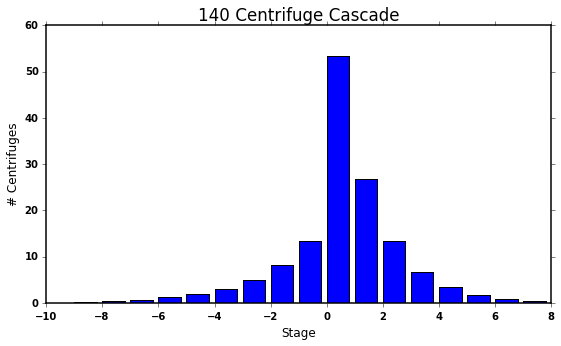

In [245]:
all_stages = np.array(strip_stages+enrich_stages)
n_centrifuges = np.sum(all_stages[:,1], axis=0)

bar_width = 0.8
bar_res = plt.bar(all_stages[:,0], all_stages[:,1], bar_width)

plt.xlabel('Stage')
plt.ylabel('# Centrifuges')
plt.title(str(int(n_centrifuges)) + " Centrifuge Cascade")
plt.legend()

plt.tight_layout()
plt.show()


Given the ideal cascade above, how does the product enrichment change with different feed enrichment?
How much new product is produced given the new feed rate?

In [246]:
Npc_mod = Npc_from_Nstages(alpha, Nfc_mod, n_stage_en)
Nwc_mod = Nwc_from_Nstages(alpha, Nfc_mod, n_stage_str)

print "Cascade optimized for feed= ", Nfc, " tails= ", Nwc
print "When used with feed= ", Nfc_mod, " product= ", Npc_mod, " tails= ", Nwc_mod 


Cascade optimized for feed=  0.0071  tails=  0.001
When used with feed=  0.2  product=  0.605435459568  tails=  0.0252250552506


In [247]:
# starting feed stages and enrichment are starting cascade values
Nfs = Nfc_mod
Fs_mod = Fc_mod
print "stage, Feed,   Product,    N_F,     N_P"
enrich_stages = []
for i in range(0, n_stage_en):  
    Nps = N_product_by_alpha(alpha, Nfs)
    Ps_mod = product_per_enr_stage(alpha, Nfs, Nps, Fs_mod)
    if (i == 1):
        W_enr1_mod = Fs_mod - Ps_mod
        Nw_enr1_mod = (Fs_mod*Nfs - Ps_mod*Nps)/W_enr1
    print i, Fs_mod, Ps_mod,  Nfs, Nps
    Nfs = Nps
    Fs_mod = Ps_mod
print "product of cascade (kg/mon)" , Fs_mod*60*60*24*30

stage, Feed,   Product,    N_F,     N_P
0 1.75134015595e-05 9.15391777472e-06 0.2 0.234714490977
1 9.15391777472e-06 4.82061327173e-06 0.234714490977 0.273395289262
2 4.82061327173e-06 2.55976514287e-06 0.273395289262 0.315819984178
3 2.55976514287e-06 1.37156097636e-06 0.315819984178 0.361552207257
4 1.37156097636e-06 7.42016363273e-07 0.361552207257 0.409938836045
5 7.42016363273e-07 4.05503476898e-07 0.409938836045 0.460134050717
6 4.05503476898e-07 2.23911281059e-07 0.460134050717 0.51115120583
7 2.23911281059e-07 1.24934982786e-07 0.51115120583 0.561937107984
product of cascade (kg/mon) 0.323831475382


In [248]:
F_strip_mod = W_enr1_mod
Nf_strip = Nw_enr1_mod

print "stage,    Feed,    W_strip,   Nf_strip,   Nw_strip"
strip_stages = []
for i in range(1, n_stage_str):  
    Nw_strip = N_waste_by_alpha(alpha, Nf_strip)
    W_strip_mod = waste_per_strip_stage(alpha, Nf_strip, Nw_strip, F_strip_mod)
    strip_stages.append([-1*i,n_mach_s])
    print i, F_strip_mod, W_strip_mod, Nf_strip, Nw_strip
    F_strip_mod = W_strip_mod
    Nf_strip = Nw_strip
    
print "waste of cascade (kg/mon)" , W_strip_mod*60*60*24*30


stage,    Feed,    W_strip,   Nf_strip,   Nw_strip
1 4.33330450298e-06 2.65225998475e-06 0.0118131604603 0.00965026462551
2 2.65225998475e-06 1.62400358486e-06 0.00965026462551 0.00788021989209
3 1.62400358486e-06 9.94718563651e-07 0.00788021989209 0.0064327267138
4 9.94718563651e-07 6.0943842992e-07 0.0064327267138 0.00524971216366
5 6.0943842992e-07 3.73468981901e-07 0.00524971216366 0.00428332270363
6 3.73468981901e-07 2.28905854087e-07 0.00428332270363 0.00349420545765
7 2.28905854087e-07 1.40320998282e-07 0.00349420545765 0.00285005129109
8 1.40320998282e-07 8.60280703979e-08 0.00285005129109 0.00232436947888
9 8.60280703979e-08 5.27472625154e-08 0.00232436947888 0.00189546349539
waste of cascade (kg/mon) 0.13672090444
